In [1]:
import random
import time

# Third-party imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp


In [2]:
torch_geometric.__version__

'2.4.0'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
user_df = pd.read_json("./MOOCCube/entities/user.json",lines=True)
user_df = user_df[user_df['course_order'].apply(lambda x: len(x) >= 5)]
# user_df = user_df.sample(1500)
user = []
data_train = []
data_test = []
for index, row in user_df.iterrows():
    user_id = row["id"]
    courses = row["course_order"]

    index_partition = int(len(courses) * 0.75)

    courses_1 = courses[:index_partition]
    courses_2 = courses[index_partition:]
        
    for course in courses_1:
        data_train.append({
                "user_id":user_id,
                "course_id":course,
                "view":1
            })
            
    for course in courses_2:
            data_test.append({
                "user_id":user_id,
                "course_id":course,
                "view":1
            })
train_df = pd.DataFrame(data_train)
test_df = pd.DataFrame(data_test)

In [5]:
train_df.head()

,user_id,course_id,view
0,U_7001215,C_course-v1:TsinghuaX+00740043_2x_2015_T2+sp,1
1,U_7001215,C_course-v1:TsinghuaX+30240184+sp,1
2,U_7001215,C_course-v1:TsinghuaX+00740043X_2015_T2+sp,1
3,U_7423998,C_course-v1:TsinghuaX+30240184_2X+sp,1
4,U_7423998,C_course-v1:SCUT+145033+sp,1


In [6]:
print("Train Size  : ", len(train_df))
print("Test Size : ", len (test_df))

Train Size  :  187699
Test Size :  85698


In [7]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train_df['user_id_idx'] = le_user.fit_transform(train_df['user_id'].values)
train_df['item_id_idx'] = le_item.fit_transform(train_df['course_id'].values)

In [8]:
train_user_ids = train_df['user_id'].unique()
train_item_ids = train_df['course_id'].unique()

print(len(train_user_ids), len(train_item_ids))

test_df = test_df[
  (test_df['user_id'].isin(train_user_ids)) & \
  (test_df['course_id'].isin(train_item_ids))
]


34917 692


In [9]:
test_df['user_id_idx'] = le_user.transform(test_df['user_id'].values)
test_df['item_id_idx'] = le_item.transform(test_df['course_id'].values)

In [10]:
n_users = train_df['user_id_idx'].nunique()
n_items = train_df['item_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  34917
Number of unique Items :  692


In [11]:
def data_loader(data, batch_size, n_usr, n_itm):

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    indices = [x for x in range(n_usr)]

    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users.sort()
    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return (
        torch.LongTensor(list(users)).to(device), 
        torch.LongTensor(list(pos_items)).to(device) + n_usr, 
        torch.LongTensor(list(neg_items)).to(device) + n_usr
    )

data_loader(train_df, 16, n_users, n_items)

(tensor([  867,  3572,  5758,  7166, 14355, 14864, 15384, 17784, 20889, 24547,
         24608, 25823, 28800, 29478, 30454, 31660], device='cuda:0'),
 tensor([35480, 35004, 35356, 35264, 35341, 35486, 35466, 35387, 35376, 35312,
         35379, 35322, 35138, 35320, 35365, 35557], device='cuda:0'),
 tensor([35112, 35006, 35086, 35085, 35480, 35032, 35219, 35544, 35323, 35273,
         35125, 35335, 35255, 35402, 35395, 35376], device='cuda:0'))

In [12]:
u_t = torch.LongTensor(train_df.user_id_idx)
i_t = torch.LongTensor(train_df.item_id_idx) + n_users

train_edge_index = torch.stack((
  torch.cat([u_t, i_t]),
  torch.cat([i_t, u_t])
)).to(device)
train_edge_index

tensor([[19930, 19930, 19930,  ..., 35310, 35359, 35309],
        [35292, 35376, 35289,  ..., 16020, 16020, 16020]], device='cuda:0')

In [13]:
train_edge_index[:,-1], train_edge_index[:, 0]

(tensor([35309, 16020], device='cuda:0'),
 tensor([19930, 35292], device='cuda:0'))

In [14]:
class LightGCNConv(MessagePassing):
  def __init__(self, **kwargs):  
    super().__init__(aggr='add')

  def forward(self, x, edge_index):
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages (no update after aggregation)
    return self.propagate(edge_index, x=x, norm=norm)

  def message(self, x_j, norm):
    return norm.view(-1, 1) * x_j

In [15]:
test_x = torch.Tensor(np.eye(5))
test_edge_index = torch.LongTensor(np.array([
  [0, 0, 1, 1, 2, 3, 3, 4],
  [2, 3, 3, 4, 0, 0, 1, 1]
]))

LightGCNConv()(test_x, test_edge_index)

tensor([[0.0000, 0.0000, 0.7071, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000, 0.7071],
        [0.7071, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7071, 0.0000, 0.0000, 0.0000]])

In [16]:
class NGCFConv(MessagePassing):
  def __init__(self, latent_dim, dropout, bias=True, **kwargs):  
    super(NGCFConv, self).__init__(aggr='add', **kwargs)

    self.dropout = dropout

    self.lin_1 = nn.Linear(latent_dim, latent_dim, bias=bias)
    self.lin_2 = nn.Linear(latent_dim, latent_dim, bias=bias)

    self.init_parameters()


  def init_parameters(self):
    nn.init.xavier_uniform_(self.lin_1.weight)
    nn.init.xavier_uniform_(self.lin_2.weight)


  def forward(self, x, edge_index):
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages
    out = self.propagate(edge_index, x=(x, x), norm=norm)

    # Perform update after aggregation
    out += self.lin_1(x)
    out = F.dropout(out, self.dropout, self.training)
    return F.leaky_relu(out)


  def message(self, x_j, x_i, norm):
    return norm.view(-1, 1) * (self.lin_1(x_j) + self.lin_2(x_j * x_i))

In [17]:
class RecSysGNN(nn.Module):
  def __init__(
      self,
      latent_dim, 
      num_layers,
      num_users,
      num_items,
      model, # 'NGCF' or 'LightGCN'
      dropout=0.1 # Only used in NGCF
  ):
    super(RecSysGNN, self).__init__()

    assert (model == 'NGCF' or model == 'LightGCN'), \
        'Model must be NGCF or LightGCN'
    self.model = model
    self.embedding = nn.Embedding(num_users + num_items, latent_dim)

    if self.model == 'NGCF':
      self.convs = nn.ModuleList(
        NGCFConv(latent_dim, dropout=dropout) for _ in range(num_layers)
      )
    else:
      self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))

    self.init_parameters()


  def init_parameters(self):
    if self.model == 'NGCF':
      nn.init.xavier_uniform_(self.embedding.weight, gain=1)
    else:
      # Authors of LightGCN report higher results with normal initialization
      nn.init.normal_(self.embedding.weight, std=0.1) 


  def forward(self, edge_index):
    emb0 = self.embedding.weight
    embs = [emb0]

    emb = emb0
    for conv in self.convs:
      emb = conv(x=emb, edge_index=edge_index)
      embs.append(emb)

    out = (
      torch.cat(embs, dim=-1) if self.model == 'NGCF' 
      else torch.mean(torch.stack(embs, dim=0), dim=0)
    )
    
    return emb0, out


  def encode_minibatch(self, users, pos_items, neg_items, edge_index):
    emb0, out = self(edge_index)
    return (
        out[users], 
        out[pos_items], 
        out[neg_items], 
        emb0[users],
        emb0[pos_items],
        emb0[neg_items]
    )

In [18]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
  # compute loss from initial embeddings, used for regulization
  reg_loss = (1 / 2) * (
    user_emb0.norm().pow(2) + 
    pos_emb0.norm().pow(2)  +
    neg_emb0.norm().pow(2)
  ) / float(len(users))
  
  # compute BPR loss from user, positive item, and negative item embeddings
  pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
  neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)
      
  bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))
      
  return bpr_loss, reg_loss

In [19]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K,epoch,df_result):
  test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())
  # compute the score of all user-item pairs
  relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

  # create dense tensor of all user-item interactions
  i = torch.stack((
    torch.LongTensor(train_df['user_id_idx'].values),
    torch.LongTensor(train_df['item_id_idx'].values)
  ))
  v = torch.ones((len(train_df)), dtype=torch.float64)
  interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items))\
      .to_dense().to(device)
  
  # mask out training user-item interactions from metric computation
  relevance_score = torch.mul(relevance_score, (1 - interactions_t))

  # compute top scoring items for each user
  topk_relevance_indices = torch.topk(relevance_score, K).indices
  topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
  topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
  topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
  topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]
  if df_result is None:
    df_result = topk_relevance_indices_df
    df_result = df_result.rename(columns={'top_rlvnt_itm': 'top_rlvnt_itm_'+str(epoch)})
  else:
    df_result = pd.merge(df_result, topk_relevance_indices_df[['user_ID', 'top_rlvnt_itm']], on='user_ID', how='left')
    df_result = df_result.rename(columns={'top_rlvnt_itm': 'top_rlvnt_itm_'+str(epoch)})

  # measure overlap between recommended (top-scoring) and held-out user-item 
  # interactions
  test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
  metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
  metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]

  metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1) 
  metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

  return metrics_df['recall'].mean(), metrics_df['precision'].mean(), df_result

In [20]:
latent_dim = 64
n_layers = 3 

EPOCHS = 50
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005 
K = 30

In [21]:
def recommend(user_embeddings,item_embeddings,user):
    user_emdedding = user_embeddings[user]
    scores = torch.matmul(user_emdedding, item_embeddings.T)
    sorted_indices = torch.argsort(scores, descending=True)
    top_N = 30
    recommended_item_indices = sorted_indices[:30]
    recommended_item_ids = le_item.inverse_transform(recommended_item_indices.cpu().numpy())
    return recommended_item_ids  

In [22]:
groupedTrain = train_df.groupby('user_id')['course_id'].apply(list).reset_index()
groupedTest = test_df.groupby('user_id')['course_id'].apply(list).reset_index()
def getUserCourses(user,df_user):
    return df_user.loc[df_user['id'] == user, 'course_order'].values[0]
def  getUserCoursesTest(user):
    # print(user)
    return groupedTest.loc[groupedTest['user_id'] == user, 'course_id'].values[0]
def  getUserCoursesTrain(user):
    return groupedTrain.loc[groupedTrain['user_id'] == user, 'course_id'].values[0]

In [23]:
users_df = test_df[["user_id", "user_id_idx"]]

users_df = users_df.drop_duplicates()
users_df.head()

,user_id,user_id_idx
0,U_7001215,19930
2,U_7423998,22589
4,U_545306,14759
7,U_7594103,23312
9,U_3234246,10534


In [24]:
def evaluate(df_user,us_em,it_em):
    # df_user = df_user.sample(500)
    results = []
    i = 0
    for index, row in df_user.iterrows():
        courses_train = getUserCoursesTrain(row["id"])
        courses_test = getUserCoursesTest(row["id"])
        resultado = users_df[users_df['user_id'] == row["id"]]['user_id_idx'].iloc[0]
        # print(resultado)
        recommended = list(recommend(us_em,it_em,int(resultado)))
        for j in courses_train:
            if j in recommended:
                recommended.remove(j)
        # print(len(recommended))
        recommended = recommended[:15]
        matches = list(set(courses_test).intersection(set(recommended)))
        results.append(
            {
                "recomendations":len(recommended),
                "matches":len(matches),
                "posible":len(courses_test)
            }
        )
        
    return results  

In [25]:
def get_precision(user_df,us_em,it_em):
    results = evaluate(user_df,us_em,it_em)
    df_evaluations = pd.DataFrame(results)
    cont = 0
    pre = 0
    for index, row in df_evaluations.iterrows():
        if row["posible"] < 15:
            precision = row["matches"]/row["posible"]
        else:
            precision = row["matches"]/15
        pre = pre + precision
        cont += 1
    return pre/cont

In [26]:
def train_and_eval(model, optimizer, train_df):
  loss_list_epoch = []
  bpr_loss_list_epoch = []
  reg_loss_list_epoch = []

  recall_list = []
  precision_list = []
  my_precision = []
  df_result = None

  for epoch in tqdm(range(EPOCHS)):
      n_batch = int(train_df.shape[0]/BATCH_SIZE)
    
      final_loss_list = []
      bpr_loss_list = []
      reg_loss_list = []
    
      model.train()
      for batch_idx in range(n_batch):

          optimizer.zero_grad()

          users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items)
          users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

          bpr_loss, reg_loss = compute_bpr_loss(
            users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
          )
          reg_loss = DECAY * reg_loss
          final_loss = bpr_loss + reg_loss

          final_loss.backward()
          optimizer.step()

          final_loss_list.append(final_loss.item())
          bpr_loss_list.append(bpr_loss.item())
          reg_loss_list.append(reg_loss.item())

      model.eval()
      with torch.no_grad():
          _, out = model(train_edge_index)
          final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
          test_topK_recall,  test_topK_precision, result_df = get_metrics(
            final_user_Embed, final_item_Embed, n_users, n_items, train_df, test_df, K,epoch,df_result
          )
          users_embedings = final_user_Embed
          
      df_result = result_df
      loss_list_epoch.append(round(np.mean(final_loss_list),4))
      bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
      reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

      recall_list.append(round(test_topK_recall,4))
      precision_list.append(round(test_topK_precision,4))
      # mp = get_precision(user_df,final_user_Embed,final_item_Embed)
      my_precision.append(1)

  return (
    loss_list_epoch, 
    bpr_loss_list_epoch, 
    reg_loss_list_epoch, 
    recall_list, 
    precision_list,final_user_Embed,final_item_Embed,my_precision,result_df
  )

In [27]:
lightgcn = RecSysGNN(
  latent_dim=latent_dim, 
  num_layers=n_layers,
  num_users=n_users,
  num_items=n_items,
  model='LightGCN'
)
lightgcn.to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(lightgcn.parameters())])

Size of Learnable Embedding :  [torch.Size([35609, 64])]


In [28]:
light_loss, light_bpr, light_reg, light_recall, light_precision,us_em,it_em,my_precision,result_df = train_and_eval(lightgcn, optimizer, train_df)

  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\s.pardob\AppData\Local\Temp\ipykernel_24096\1363382950.py:12: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:607.)
  interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items))\


In [29]:
# result_df.head()

In [30]:
courses_df = train_df[["course_id","item_id_idx"]]
courses_df = courses_df.drop_duplicates()
courses_df = courses_df.sort_values(by='item_id_idx')
courses_df.head()

users_ids_df = train_df[["user_id","user_id_idx"]]
users_ids_df = users_ids_df.drop_duplicates()
users_ids_df = users_ids_df.sort_values(by='user_id_idx')
users_ids_df.head()


,user_id,user_id_idx
152102,U_10000144,0
107316,U_10000168,1
45857,U_10000185,2
53320,U_10000205,3
118854,U_10000338,4


In [31]:
def map_ids_to_names(ids_list):
    return [courses_df.loc[courses_df['item_id_idx'] == id, 'course_id'].values[0] for id in ids_list]

In [32]:
for i in range(EPOCHS):
    result_df['top_rlvnt_itm_'+str(i)] = result_df['top_rlvnt_itm_'+str(i)].apply(map_ids_to_names)

In [33]:
# result_df.head()

In [34]:
result_df =  pd.merge(result_df, users_ids_df, right_on='user_id_idx',left_on="user_ID", how='inner')

In [35]:
# result_df.head()

In [36]:
result_df["courses_test"] = result_df["user_id"].apply(getUserCoursesTest)
result_df["courses_train"] = result_df["user_id"].apply(getUserCoursesTrain)

U_10000144
U_10000168
U_10000185
U_10000205
U_10000338
U_10000415
U_10000491
U_10000598
U_1000063
U_10000658
U_10000705
U_10001302
U_10001348
U_1000149
U_10001784
U_10002175
U_10002610
U_10002868
U_1000541
U_1000603
U_10006512
U_10006815
U_1000752
U_1000763
U_10008274
U_10008331
U_10008418
U_1000850
U_10008612
U_10009183
U_10009229
U_10009424
U_10009468
U_1001200
U_1001354
U_10016833
U_10017076
U_10017100
U_10017149
U_10017217
U_10017429
U_10017438
U_10017854
U_10017894
U_10017915
U_10017973
U_10018774
U_10018894
U_10018930
U_10019223
U_10019770
U_10019785
U_10020238
U_10020438
U_10020661
U_10020747
U_10021012
U_10021027
U_10021044
U_10021046
U_10021069
U_10021286
U_10021673
U_10021722
U_1002258
U_10022655
U_10023829
U_10023837
U_10024003
U_10024070
U_10024265
U_1002445
U_10025408
U_10025467
U_10025608
U_10025900
U_10025906
U_10025962
U_10025999
U_10026024
U_10026175
U_10026217
U_10026492
U_1002679
U_10026827
U_1002696
U_1002713
U_1002720
U_10027644
U_1002765
U_10027702
U_10027847
U_10

In [37]:
# result_df.head()

In [38]:
precision_list = []
rank_list = []
for e in range(EPOCHS):
    num_users = 0
    t_precision = 0
    rank = 0
    for index, row in result_df.iterrows():
        test_courses = set(row["courses_test"])
        taken_course =set(row["courses_train"])
        recommended = row["top_rlvnt_itm_"+str(e)]
        if set(recommended).intersection(taken_course):
            print("dios")
        for j in recommended:
            if j in taken_course:
                recommended.remove(j)
        # print(len(recommended))
        recommendations =set(recommended[:15])
        
        
        # print(len(test_courses))
        precision = len(test_courses.intersection(recommendations))/len(test_courses)
        if len(test_courses) < 15:
            precision = len(test_courses.intersection(recommendations))/len(test_courses)
        else:
            precision = len(test_courses.intersection(recommendations))/15
        num_users += 1
        t_precision += precision
        
        r = 0
        found = False
        while r < len(row["top_rlvnt_itm_"+str(e)]) and not found:
            if row["top_rlvnt_itm_"+str(e)][r] in row["courses_test"]:
                found = True
            r += 1
        rank += 1/r
    precision_list.append(t_precision/num_users)
    rank_list.append((1/num_users)*rank)
    

In [44]:
precision_list_10 = []
for e in range(EPOCHS):
    num_users = 0
    t_precision = 0
    rank = 0
    for index, row in result_df.iterrows():
        test_courses = set(row["courses_test"])
        taken_course =set(row["courses_train"])
        recommended = row["top_rlvnt_itm_"+str(e)]
        if set(recommended).intersection(taken_course):
            print("dios")
        for j in recommended:
            if j in taken_course:
                recommended.remove(j)
        # print(len(recommended))
        recommendations =set(recommended[:10])
        
        
        # print(len(test_courses))
        precision = len(test_courses.intersection(recommendations))/len(test_courses)
        if len(test_courses) < 10:
            precision = len(test_courses.intersection(recommendations))/len(test_courses)
        else:
            precision = len(test_courses.intersection(recommendations))/10
        num_users += 1
        t_precision += precision
        
        
    precision_list_10.append(t_precision/num_users)

In [45]:
precision_list_5 = []
for e in range(EPOCHS):
    num_users = 0
    t_precision = 0
    rank = 0
    for index, row in result_df.iterrows():
        test_courses = set(row["courses_test"])
        taken_course =set(row["courses_train"])
        recommended = row["top_rlvnt_itm_"+str(e)]
        if set(recommended).intersection(taken_course):
            print("dios")
        for j in recommended:
            if j in taken_course:
                recommended.remove(j)
        # print(len(recommended))
        recommendations =set(recommended[:5])
        
        
        # print(len(test_courses))
        precision = len(test_courses.intersection(recommendations))/len(test_courses)
        if len(test_courses) < 5:
            precision = len(test_courses.intersection(recommendations))/len(test_courses)
        else:
            precision = len(test_courses.intersection(recommendations))/5
        num_users += 1
        t_precision += precision
        
        
    precision_list_5.append(t_precision/num_users)

In [46]:
print(precision_list)

[0.43140809637931754, 0.45817945193106635, 0.47950071188751736, 0.49187384207789747, 0.4975251392426409, 0.4991513168568759, 0.4981592913932468, 0.4989710473772691, 0.4965639087041281, 0.4954439002746436, 0.49565549906429823, 0.49487008299621144, 0.4921163945027681, 0.4907077616245082, 0.48749945111101756, 0.48599211994263386, 0.48157788844918553, 0.4805816959116231, 0.4741795163910483, 0.47364327700697073, 0.47410902899991586, 0.46648287258305593, 0.46388431593990653, 0.4607973444235173, 0.4596156219255299, 0.4509569269278029, 0.44842559525736964, 0.4439288761567335, 0.443918515335736, 0.44014670735609207, 0.4340264832016732, 0.4230136196026773, 0.4288917645219766, 0.4217628509792814, 0.41539483863566956, 0.40954499895130736, 0.4080259011417214, 0.4070237602736129, 0.4023520759645018, 0.3904823979723053, 0.39608355021621083, 0.38987352475624903, 0.3842101701539827, 0.38495230970529787, 0.3725001708935057, 0.3720413004178833, 0.36819375116265324, 0.3673014974479912, 0.36111999386980376

In [47]:
print(rank_list)

[0.3416471904994872, 0.3634473904390093, 0.38253359184868924, 0.39364257488960086, 0.40110571977719267, 0.40409705576577504, 0.4082639044720893, 0.4098784468559568, 0.410510834844805, 0.41208081499855037, 0.4131926735115556, 0.41437960606822205, 0.4131397257170043, 0.41456826709795414, 0.411970289634735, 0.41253592358934993, 0.41151290673154906, 0.41095391277148496, 0.40737502513724544, 0.40843799501374584, 0.40853798750898784, 0.4033971530636126, 0.40135471529401034, 0.4005917289604464, 0.3998239262448243, 0.39268088545866336, 0.3913733939926861, 0.38844592075321077, 0.38916658056909115, 0.3850921212994987, 0.38111915723190387, 0.37263918046344696, 0.3769592018217797, 0.37080673821241444, 0.3641083735582584, 0.3616011120334749, 0.3588425613574291, 0.35633662817817763, 0.3526466072284081, 0.34444149789449746, 0.34950643084391647, 0.3433340409249899, 0.34004790166099835, 0.33788304736191904, 0.32881766240067273, 0.32683499069330624, 0.32422776244918455, 0.3238435959851515, 0.31744208540

In [48]:
epoch_list = [(i+1) for i in range(EPOCHS)]

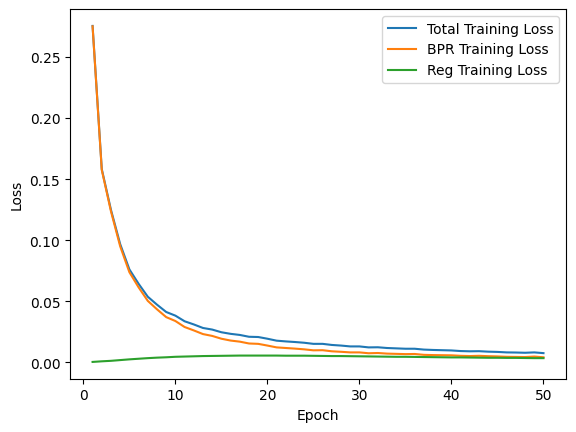

In [49]:
plt.plot(epoch_list, light_loss, label='Total Training Loss')
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')
plt.plot(epoch_list, light_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

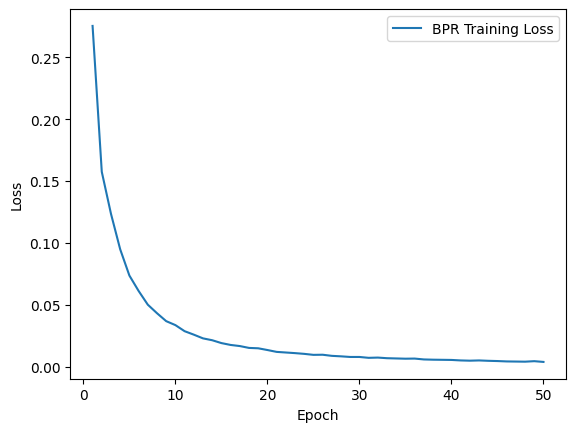

In [55]:
# plt.plot(epoch_list, light_loss, label='Total Training Loss')
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')
# plt.plot(epoch_list, light_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

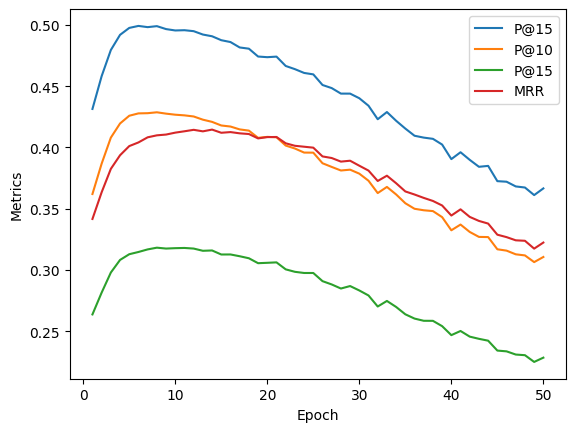

In [50]:
plt.plot(epoch_list, precision_list, label='P@15')
plt.plot(epoch_list, precision_list_10, label='P@10')
plt.plot(epoch_list, precision_list_5, label='P@15')
plt.plot(epoch_list, rank_list, label='MRR')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

In [51]:
print(max(precision_list))

0.4991513168568759


In [54]:
print(max(precision_list_5))

0.3182213057631934


In [53]:
print(max(precision_list_10))

0.4286775305247726


In [52]:
print(max(rank_list))

0.41456826709795414
